# Ujian Akhir Semester - Big Data & Predictive Analytic Lanjut
# Anggota :
- 22.11.4613 - Alvin Christ Yudantama
- 22.11.4659 - Rizky Fadly Pramudya Wardana
- 22.11.4656 - Dico Fathatul Rizki

# Kelas :  
- Big Data & Predictive Analytic Lanjut IF 08

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# Load dataset
drive.mount('/content/drive')
dataset_path = '/content/drive/MyDrive/BigDataAdvance/uas/Disease_symptom_and_patient_profile_dataset.csv'
data = pd.read_csv(dataset_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Preprocessing Data

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   disease               349 non-null    object
 1   fever                 349 non-null    int8  
 2   cough                 349 non-null    int8  
 3   fatigue               349 non-null    int8  
 4   difficulty_breathing  349 non-null    int8  
 5   age                   349 non-null    int64 
 6   gender                349 non-null    int8  
 7   blood_pressure        349 non-null    int8  
 8   cholesterol_level     349 non-null    int8  
 9   outcome_variable      349 non-null    int8  
dtypes: int64(1), int8(8), object(1)
memory usage: 8.3+ KB

Missing Values:
disease                 0
fever                   0
cough                   0
fatigue                 0
difficulty_breathing    0
age                     0
gender                  0
blood_pressure         

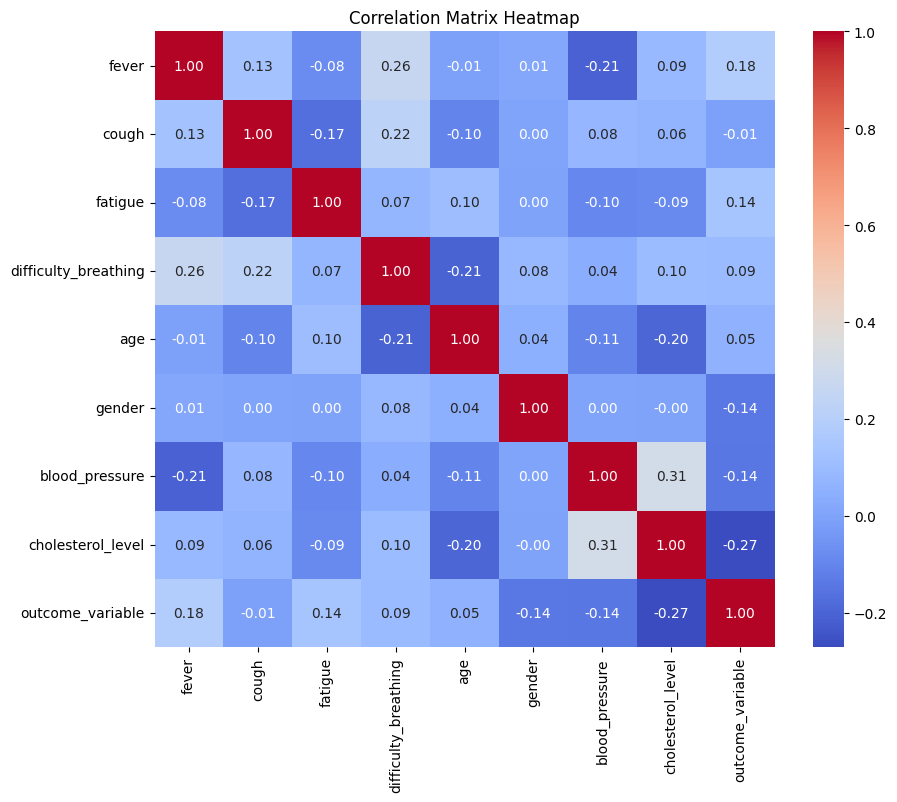

In [ ]:
# 1. Preprocessing Data
# Rename columns for better readability
data.rename(columns=lambda x: x.strip().replace(' ', '_').lower(), inplace=True)

# Display basic information about the dataset
print("Dataset Info:")
data.info()

# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())

# Handle missing values (if necessary, using imputation or removal)
data = data.dropna()  # Dropping rows with missing values for simplicity

# Convert data types if required
# Example: Assume `age` is a string that needs conversion to numeric
if 'age' in data.columns:
    data['age'] = pd.to_numeric(data['age'], errors='coerce')

# Encode categorical variables, excluding the 'disease' column
categorical_columns = data.select_dtypes(include=['object']).columns
categorical_columns = [col for col in categorical_columns if col != 'disease']
for col in categorical_columns:
    data[col] = data[col].astype('category').cat.codes

# Summary statistics
print("\nSummary Statistics:")
print(data.describe(include='all'))

# Correlation matrix
numerical_data = data.select_dtypes(include=['number'])
print("\nCorrelation Matrix:")
correlation_matrix = numerical_data.corr()
print(correlation_matrix)

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

In [ ]:
data.head()

,disease,fever,cough,fatigue,difficulty_breathing,age,gender,blood_pressure,cholesterol_level,outcome_variable
0,Influenza,1,0,1,1,19,0,1,2,1
1,Common Cold,0,1,1,0,25,0,2,2,0
2,Eczema,0,1,1,0,25,0,2,2,0
3,Asthma,1,1,0,1,25,1,2,2,1
4,Asthma,1,1,0,1,25,1,2,2,1


#EDA

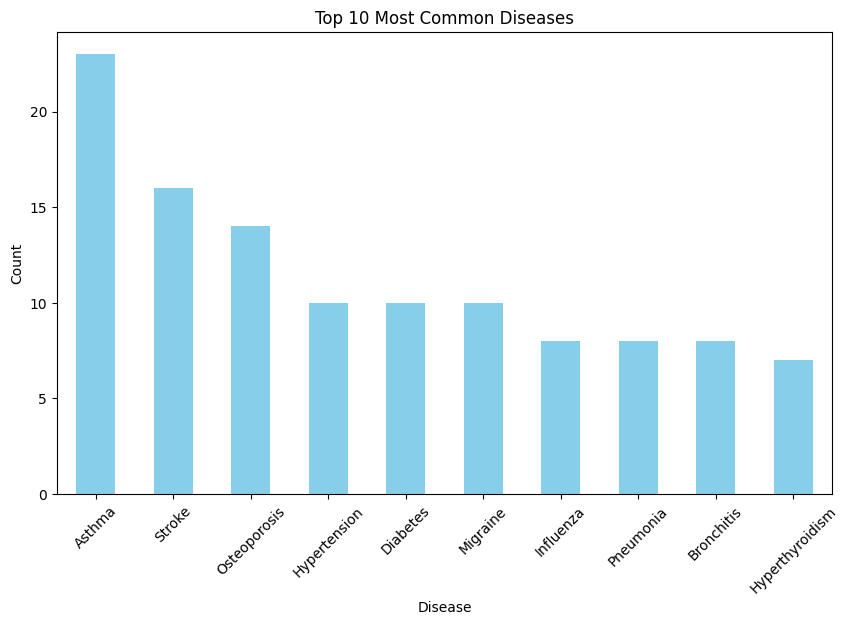

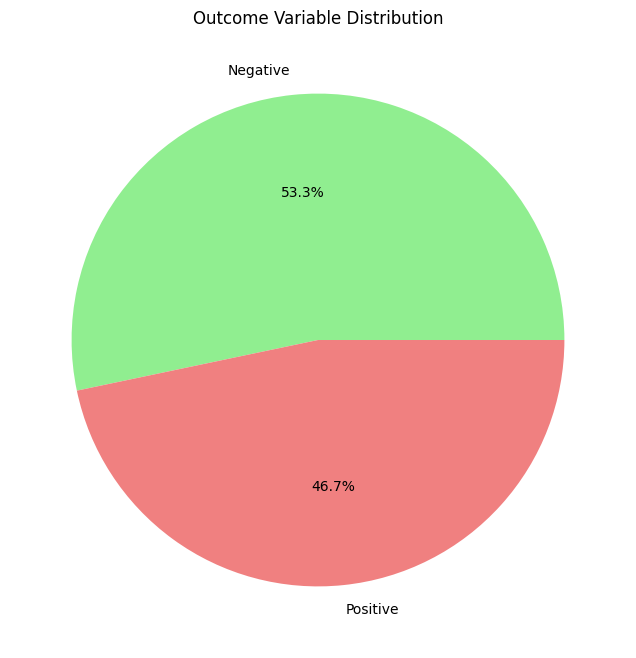

<ipython-input-26-025e0e1909cf>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='gender', y='age', data=data, palette='Set2')


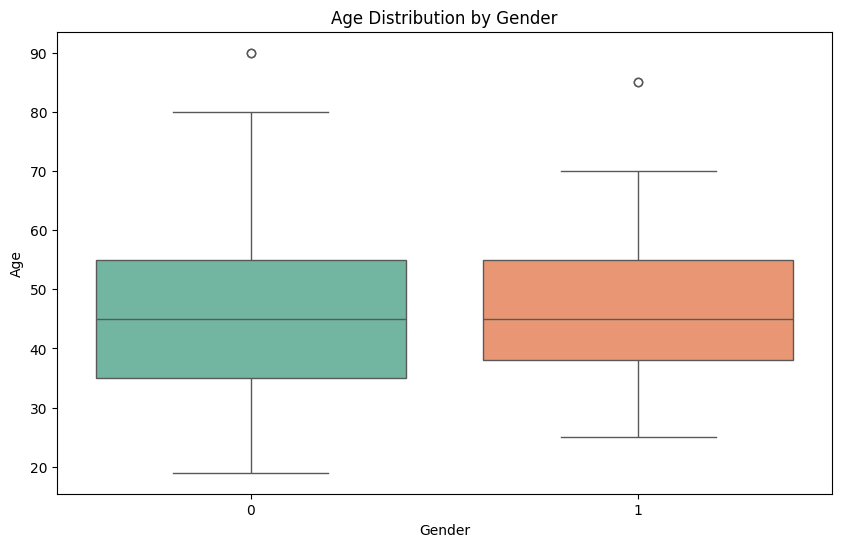

<ipython-input-26-025e0e1909cf>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='blood_pressure', data=data, palette='muted')


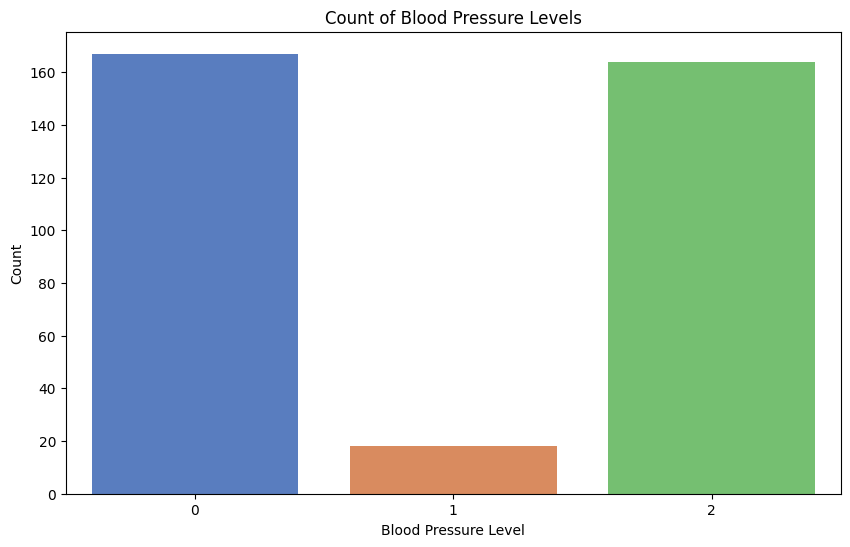

In [ ]:
# 2. Exploratory Data Analysis (EDA)
# Bar chart: Distribution of diseases
plt.figure(figsize=(10, 6))
data['disease'].value_counts().nlargest(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Most Common Diseases')
plt.xlabel('Disease')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()
print(" ")

# Pie chart: Outcome variable
plt.figure(figsize=(8, 8))
data['outcome_variable'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'], labels=['Negative', 'Positive'])
plt.title('Outcome Variable Distribution')
plt.ylabel('')
plt.show()
print(" ")

# Box plot: Age distribution by gender
plt.figure(figsize=(10, 6))
sns.boxplot(x='gender', y='age', data=data, palette='Set2')
plt.title('Age Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Age')
plt.show()
print(" ")

# Count plot: Blood pressure levels
plt.figure(figsize=(10, 6))
sns.countplot(x='blood_pressure', data=data, palette='muted')
plt.title('Count of Blood Pressure Levels')
plt.xlabel('Blood Pressure Level')
plt.ylabel('Count')
plt.show()
print(" ")

#Modeling

In [ ]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LogisticRegression, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

In [ ]:
# Start Spark session
spark = SparkSession.builder.appName("DiseasePrediction").getOrCreate()

# Load dataset
dataset_path = '/content/drive/MyDrive/BigDataAdvance/uas/Disease_symptom_and_patient_profile_dataset.csv'
data = pd.read_csv(dataset_path)

# Preprocessing in Pandas
# Rename columns for better readability
data.rename(columns=lambda x: x.strip().replace(' ', '_').lower(), inplace=True)

# Drop rows with missing values for simplicity
data = data.dropna()

# Encode categorical variables
data['outcome_variable'] = data['outcome_variable'].astype('category').cat.codes
categorical_columns = ['fever', 'cough', 'fatigue', 'difficulty_breathing', 'gender', 'blood_pressure', 'cholesterol_level']
for col in categorical_columns:
    data[col] = data[col].astype('category').cat.codes

# Convert Pandas DataFrame to Spark DataFrame
data_spark = spark.createDataFrame(data)

# Prepare data for Machine Learning
# Define feature columns and target column
feature_columns = ['fever', 'cough', 'fatigue', 'difficulty_breathing', 'age', 'gender', 'blood_pressure', 'cholesterol_level']
target_column = 'outcome_variable'

# Assemble features
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# Split data into training and testing sets
train_data, test_data = data_spark.randomSplit([0.8, 0.2], seed=42)

# Define models
rf = RandomForestClassifier(featuresCol='features', labelCol=target_column, predictionCol='prediction')
gbt = GBTClassifier(featuresCol='features', labelCol=target_column, predictionCol='prediction')
lr = LogisticRegression(featuresCol='features', labelCol=target_column, predictionCol='prediction')
nb = NaiveBayes(featuresCol='features', labelCol=target_column, predictionCol='prediction')

# Create pipelines
rf_pipeline = Pipeline(stages=[assembler, rf])
gbt_pipeline = Pipeline(stages=[assembler, gbt])
lr_pipeline = Pipeline(stages=[assembler, lr])
nb_pipeline = Pipeline(stages=[assembler, nb])

# Train models
rf_model = rf_pipeline.fit(train_data)
gbt_model = gbt_pipeline.fit(train_data)
lr_model = lr_pipeline.fit(train_data)
nb_model = nb_pipeline.fit(train_data)

# Make predictions
rf_predictions = rf_model.transform(test_data)
gbt_predictions = gbt_model.transform(test_data)
lr_predictions = lr_model.transform(test_data)
nb_predictions = nb_model.transform(test_data)

# Evaluate models
evaluators = {
    'accuracy': MulticlassClassificationEvaluator(labelCol=target_column, predictionCol='prediction', metricName='accuracy'),
    'f1': MulticlassClassificationEvaluator(labelCol=target_column, predictionCol='prediction', metricName='f1'),
    'roc_auc': BinaryClassificationEvaluator(labelCol=target_column, rawPredictionCol='rawPrediction', metricName='areaUnderROC')
}

results = {}
for model_name, predictions in zip(['Random Forest', 'GBT', 'Logistic Regression', 'Naive Bayes'],
                                    [rf_predictions, gbt_predictions, lr_predictions, nb_predictions]):
    results[model_name] = {
        'accuracy': evaluators['accuracy'].evaluate(predictions),
        'f1': evaluators['f1'].evaluate(predictions),
        'roc_auc': evaluators['roc_auc'].evaluate(predictions)
    }

# Display results
for model, metrics in results.items():
    print(f"\nModel: {model}")
    for metric_name, value in metrics.items():
        print(f"{metric_name.capitalize()}: {value:.4f}")


Model: Random Forest
Accuracy: 0.6230
F1: 0.6160
Roc_auc: 0.7900

Model: GBT
Accuracy: 0.7213
F1: 0.7230
Roc_auc: 0.8226

Model: Logistic Regression
Accuracy: 0.5410
F1: 0.5425
Roc_auc: 0.6149

Model: Naive Bayes
Accuracy: 0.5574
F1: 0.5624
Roc_auc: 0.4527


#Hyperparameter Tuning Model

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Define models for hyperparameter tuning
rf = RandomForestClassifier(featuresCol='features', labelCol=target_column, predictionCol='prediction')
gbt = GBTClassifier(featuresCol='features', labelCol=target_column, predictionCol='prediction')
# Create pipelines
rf_pipeline = Pipeline(stages=[assembler, rf])
gbt_pipeline = Pipeline(stages=[assembler, gbt])

# Define parameter grids
rf_param_grid = ParamGridBuilder()\
    .addGrid(rf.numTrees, [10, 50, 100])\
    .addGrid(rf.maxDepth, [5, 10, 15])\
    .build()

gbt_param_grid = ParamGridBuilder()\
    .addGrid(gbt.maxDepth, [5, 10, 15])\
    .addGrid(gbt.maxIter, [10, 50, 100])\
    .build()

# Define evaluator
evaluator = MulticlassClassificationEvaluator(labelCol=target_column, predictionCol='prediction', metricName='accuracy')

# CrossValidator for Random Forest
rf_cv = CrossValidator(estimator=rf_pipeline,
                       estimatorParamMaps=rf_param_grid,
                       evaluator=evaluator,
                       numFolds=3)

# CrossValidator for Gradient Boosted Tree
gbt_cv = CrossValidator(estimator=gbt_pipeline,
                        estimatorParamMaps=gbt_param_grid,
                        evaluator=evaluator,
                        numFolds=3)

# Train models with hyperparameter tuning
rf_cv_model = rf_cv.fit(train_data)
gbt_cv_model = gbt_cv.fit(train_data)

# Evaluate tuned models
rf_tuned_predictions = rf_cv_model.transform(test_data)
gbt_tuned_predictions = gbt_cv_model.transform(test_data)

# Evaluate metrics for tuned models
rf_tuned_accuracy = evaluator.evaluate(rf_tuned_predictions)
gbt_tuned_accuracy = evaluator.evaluate(gbt_tuned_predictions)

roc_evaluator = BinaryClassificationEvaluator(labelCol=target_column, rawPredictionCol='rawPrediction', metricName='areaUnderROC')
rf_tuned_auc = roc_evaluator.evaluate(rf_tuned_predictions)
gbt_tuned_auc = roc_evaluator.evaluate(gbt_tuned_predictions)

# Display results
print("\nTuned Random Forest Results:")
print(f"Accuracy: {rf_tuned_accuracy:.4f}")
print(f"AUC ROC: {rf_tuned_auc:.4f}")

print("\nTuned Gradient Boosted Tree Results:")
print(f"Accuracy: {gbt_tuned_accuracy:.4f}")
print(f"AUC ROC: {gbt_tuned_auc:.4f}")

# Stop Spark session
spark.stop()



Tuned Random Forest Results:
Accuracy: 0.7049
AUC ROC: 0.8277

Tuned Gradient Boosted Tree Results:
Accuracy: 0.7377
AUC ROC: 0.8288
